<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

from catboost import CatBoostRegressor

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import time

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Решил сразу убрать выбросы, так как они мешают прогнозу.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


<AxesSubplot:>

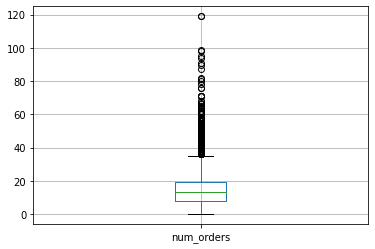

In [6]:
data.boxplot()

In [7]:
data = data.query('num_orders < 40')

<AxesSubplot:xlabel='datetime'>

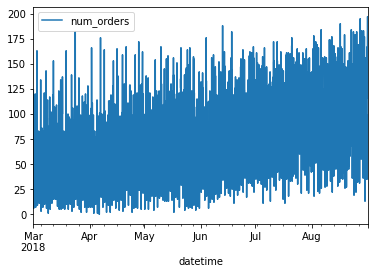

In [8]:
data = data.resample('1H').sum()
data.plot()

## Анализ

Так как на графике с ресемплированием по 1 часу ничего особо не видно, ресемплируем по дням.

<AxesSubplot:xlabel='datetime'>

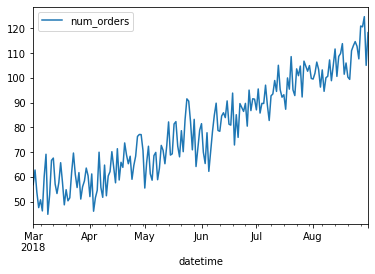

In [9]:
data.resample('1D').mean().plot()

<AxesSubplot:xlabel='datetime'>

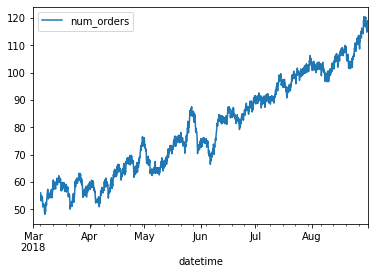

In [10]:
data.rolling(100).mean().plot()

На графиках наблюдается восходящий тренд.

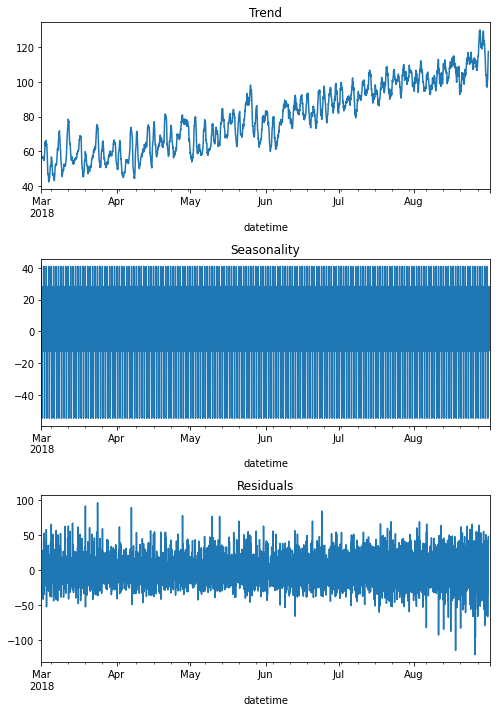

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(7, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графиках выше сложно разобрать что-то кроме тренда, поэтому сократим промежуток до недели(с понедельника по воскресенье).

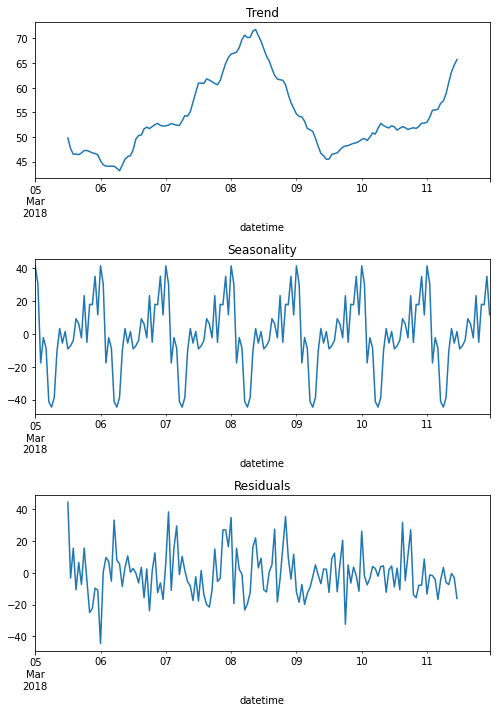

In [12]:
decomposed = seasonal_decompose(data['2018-03-05' : '2018-03-11'])

plt.figure(figsize=(7, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике с трендом видно, что больше всего заказов в среду, четверг и воскресенье.


На графике с сезоностью можно увидеть закономерость того, что ночью заказов почти нет, когда днем и вечером их много. 

<AxesSubplot:xlabel='datetime'>

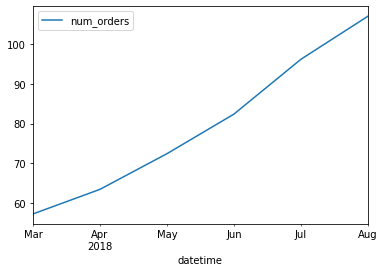

In [13]:
data.resample('1M').mean().plot()

На разбивке по месяцам также отслеживается восходящий тренд.

<AxesSubplot:xlabel='datetime'>

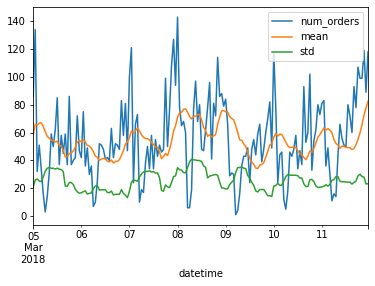

In [14]:
data_1d = data.copy()
data_1d['mean'] = data_1d['num_orders'].rolling(15).mean()
data_1d['std'] = data_1d['num_orders'].rolling(15).std()
data_1d['2018-03-05' : '2018-03-11'].plot() 

*Выводы:* 

*1)За представленный период можно отследить восходящий тренд;*

*2)За рассмотренный мной период(1 неделя) наблюдается рост количества заказов в среду, четверг и в воскресенье. А также ночью заказов гораздо меньше, чем днем и вечером в час пик.*

## Обучение

Напишем функцию для создания признаков.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [16]:
df = make_features(data, 24, 10)
df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df.dropna()

In [18]:
df.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,120,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,75,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,64,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,20,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


Разделим выборки на обучающую и тествоую.

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Напишем функцию для подсчета RMSE.

In [20]:
def rmse(true, pred):
    return (mean_squared_error(true, pred))**0.5

In [21]:
RMSE_score = make_scorer(rmse, greater_is_better=False)

### Линейная регрессия

Собираюсь применять кросс-валидацию, но не обычную, так как для временных рядов нужна другая - TimeSeriesSplit.

In [22]:
%%time
cv = TimeSeriesSplit(n_splits=10)
regression = LinearRegression()
regression.fit(features_train, target_train)
regression_cv_score = cross_val_score(regression, features_train,target_train,scoring=RMSE_score,cv=cv).mean()*(-1)
print('Среднее RMSE модели линейной регрессии на кросс-валидации:', regression_cv_score )

Среднее RMSE модели линейной регрессии на кросс-валидации: 24.49913982581239
CPU times: user 523 ms, sys: 1.14 s, total: 1.67 s
Wall time: 1.58 s


### Случайный лес

Применяю GridSearchCV для подбора гиперпараметров.

In [53]:
%%time
random = RandomForestRegressor(random_state=12345)
forest_parametrs = {'n_estimators': range(5, 30, 5),
                    'max_depth': range(1, 15, 2),
                    'min_samples_leaf': range(1,5),
                    'min_samples_split': range(2,8,2)}
random_forest = GridSearchCV(random, forest_parametrs, scoring=RMSE_score, cv=cv)
random_forest.fit(features_train, target_train)

print(random_forest.best_params_)
print('--'*10)
print(random_forest.score(features_train, target_train) * (-1))

{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
--------------------
12.9342354974527
CPU times: user 12min 40s, sys: 2.27 s, total: 12min 43s
Wall time: 12min 43s


### Модель CatBoost

In [54]:
%%time
cat = CatBoostRegressor(random_state=12345)
cat_param = {'learning_rate': [0.03, 0.1, 0.05],
                'depth': [4, 20, 1],
             'iterations':[5, 50, 5]
            }
cat_boost = GridSearchCV(cat, cat_param, scoring=RMSE_score, cv=cv)
cat_boost.fit(features_train, target_train, verbose=100)

0:	learn: 29.0090873	total: 48.4ms	remaining: 194ms
4:	learn: 27.7222616	total: 56ms	remaining: 0us
0:	learn: 28.5110409	total: 2.75ms	remaining: 11ms
4:	learn: 27.1204608	total: 10.3ms	remaining: 0us
0:	learn: 28.6919376	total: 2ms	remaining: 8.01ms
4:	learn: 27.4026117	total: 8.65ms	remaining: 0us
0:	learn: 29.7530240	total: 2.19ms	remaining: 8.76ms
4:	learn: 28.4314429	total: 9.49ms	remaining: 0us
0:	learn: 29.9045697	total: 2.15ms	remaining: 8.62ms
4:	learn: 28.6226463	total: 9.25ms	remaining: 0us
0:	learn: 30.9769647	total: 2.23ms	remaining: 8.9ms
4:	learn: 29.6148566	total: 9.92ms	remaining: 0us
0:	learn: 31.2676307	total: 2.3ms	remaining: 9.2ms
4:	learn: 29.8644480	total: 10.2ms	remaining: 0us
0:	learn: 31.7831340	total: 2.35ms	remaining: 9.42ms
4:	learn: 30.3419142	total: 10.5ms	remaining: 0us
0:	learn: 32.5971316	total: 2.68ms	remaining: 10.7ms
4:	learn: 31.0953164	total: 11.3ms	remaining: 0us
0:	learn: 33.4536289	total: 2.44ms	remaining: 9.75ms
4:	learn: 31.8821889	total: 11m

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff54a07a160>,
             param_grid={'depth': [4, 20, 1], 'iterations': [5, 50, 5],
                         'learning_rate': [0.03, 0.1, 0.05]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [55]:
print(cat_boost.best_params_)
print('--' * 10)
print(cat_boost.score(features_train, target_train) * (-1))

{'depth': 4, 'iterations': 50, 'learning_rate': 0.1}
--------------------
21.827072084321816


*В итоге, случайный лес - модель с наименьшим RMSE, ее и будем использовать для финального теста.*

## Тестирование

Создадим константную модель для проверки модели на адекватность.

In [56]:
pred_median = target_train.median() * np.ones(target_test.shape)
print('RMSE константной модели:', rmse(target_test, pred_median))

RMSE константной модели: 51.46611859890314


In [57]:
best_model = RandomForestRegressor(max_depth=13, min_samples_leaf=4, min_samples_split=2, n_estimators=25)
best_model.fit(features_train, target_train)
print('RMSE случайного леса на тестовой выборке равен', rmse(target_test, best_model.predict(features_test)))

RMSE случайного леса на тестовой выборке равен 33.888695816381976


<AxesSubplot:title={'center':'График распределения предсказанных и истинных значениий'}, xlabel='Предсказанные / Истинные значения', ylabel='Количество'>

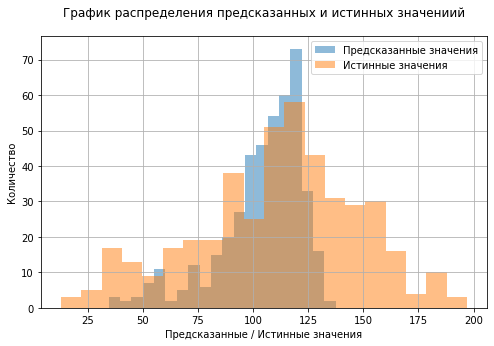

In [58]:
plt.figure(figsize=(8, 5))
pd.Series(best_model.predict(features_test)).hist(bins=20, alpha=0.5)
pd.Series(target_test).hist(bins=20, alpha=0.5)
plt.legend(['Предсказанные значения', 'Истинные значения'])
plt.title('График распределения предсказанных и истинных значениий', y=1.05)
plt.xlabel('Предсказанные / Истинные значения')
plt.ylabel('Количество')
plt.subplot()

<AxesSubplot:xlabel='datetime'>

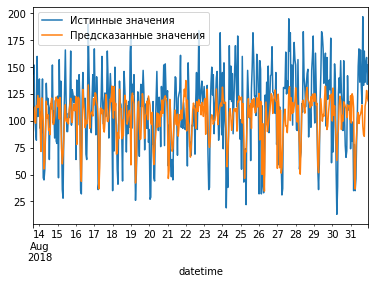

In [59]:
df2 = pd.DataFrame(target_test)
df2 = df2.rename(columns = {'num_orders':'Истинные значения'})
df2['Предсказанные значения'] = best_model.predict(features_test)
df2.plot()

**Общий вывод:** 

1)Периоды с наиболее пиковой нагрузкой для заказа такси - день и вечер(до 00:00) среды, четверга и воскресенья;

2)Хорошей моделью для прогнозирования будет случайный лес. RMSE на константной модели больше, чем на тестовых данных, что делает эту модель адекватной.